In [9]:
import torch

import numpy as np
import torch.nn as nn

from adamp import AdamP
from torch.optim import Adam
from box import Box
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
from architecture.nets.pignn import FlowPIGNN
from utils import plot_prediction_vs_real

import os
from datetime import datetime

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Load the data into train and test datasets
batch_size = 64
data_folder = 'D:\AI2P\data\Case_01\graphs'
data_range = range(30005, 42000 + 1, 5)

class GraphDataset(Dataset):
    def __init__(self, root, data_range, transform=None, pre_transform=None):
        super(GraphDataset, self).__init__(root, transform, pre_transform)
        self.data_range = data_range
        self.graph_paths = self.load_graph_paths()

    def load_graph_paths(self):
        graph_paths = [f"{data_folder}/graph_{i}.pt" for i in self.data_range]
        return graph_paths

    def len(self):
        return len(self.graph_paths)

    def get(self, idx):
        graph_path = self.graph_paths[idx]
        graph_data = torch.load(graph_path)
        return graph_data

dataset = GraphDataset(root=data_folder, data_range=data_range)

total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [4]:
model_cfg = Box({
        'edge_in_dim': 2,
        'node_in_dim': 5,
        'global_in_dim': 2,
        'n_pign_layers': 3,
        'edge_hidden_dim': 50,
        'node_hidden_dim': 50,
        'global_hidden_dim': 50,
        'num_nodes': 10,
        'residual': True,
        'input_norm': True,
        'pign_mlp_params': {'num_neurons': [256, 128],
                           'hidden_act': 'ReLU',
                           'out_act': 'ReLU'},
        'reg_mlp_params': {'num_neurons': [64, 128, 256],
                           'hidden_act': 'ReLU',
                           'out_act': 'ReLU'},
})

In [5]:
num_epochs = 200

def train():
    time = datetime.now().strftime('%Y%m%d%H%M%S')
    output_folder = f"results/{time}"
    os.makedirs(output_folder)

    model = FlowPIGNN(**model_cfg).to(device)
    print(model)

    if torch.cuda.is_available():
        optimizer = AdamP(model.parameters(), lr=1e-3)
    else:
        optimizer = Adam(model.parameters(), lr=1e-3)

    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50)

    for epoch in range(num_epochs):
        train_losses = []
        for i, batch in enumerate(train_loader):
            print(f"processing batch: {i+1}/{len(train_loader)}")
            batch = batch.to(device)
            nf = torch.cat((batch.x.to(device), batch.pos.to(device)), dim=-1).float()
            ef = batch.edge_attr.to(device).float()
            gf = batch.global_feats.to(device).float()
            pred = model(batch, nf, ef, gf)
            loss = criterion(pred, batch.y.reshape(-1, pred.size(1)))
            train_losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

        with torch.no_grad():
            model.eval()
            val_losses = []
            for batch in val_loader:
                batch = batch.to(device)
                nf = torch.cat((batch.x.to(device), batch.pos.to(device)), dim=-1).float()
                ef = batch.edge_attr.to(device).float()
                gf = batch.global_feats.to(device).float()
                pred = model(batch, nf, ef, gf)
                val_loss = criterion(pred, batch.y.reshape(-1, pred.size(1)))
                val_losses.append(val_loss.item())
                model.train()

        learning_rate = optimizer.param_groups[0]['lr']
        print(f"step {epoch}/{num_epochs}, lr: {learning_rate}, training loss: {np.mean(train_losses)}, validation loss: {np.mean(val_losses)}")

        # Save model pointer
        torch.save(model.state_dict(), f"{output_folder}/pignn_{epoch}.pt")

train()

FlowPIGNN(
  (gn_layers): ModuleList(
    (0): PIGN(
      (edge_model): MLP 
      Input Norm : BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 
      Dimensions : [14, 256, 128, 50] 
      Hidden Act. : ReLU() 
      Out Act. : ReLU() 
      
      (node_model): MLP 
      Input Norm : BatchNorm1d(57, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 
      Dimensions : [57, 256, 128, 50] 
      Hidden Act. : ReLU() 
      Out Act. : ReLU() 
      
      (global_model): MLP 
      Input Norm : BatchNorm1d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 
      Dimensions : [102, 256, 128, 50] 
      Hidden Act. : ReLU() 
      Out Act. : ReLU() 
      
    )
    (1-2): 2 x PIGN(
      (edge_model): MLP 
      Input Norm : BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 
      Dimensions : [200, 256, 128, 50] 
      Hidden Act. : ReLU() 
      Out Act. : ReLU() 
      
      (node_model)

C:\Users\Matth\AppData\Local\Temp\ipykernel_22256\914739.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_data = torch.load(graph_path)


processing batch: 2/27
processing batch: 3/27
processing batch: 4/27
processing batch: 5/27
processing batch: 6/27
processing batch: 7/27
processing batch: 8/27
processing batch: 9/27
processing batch: 10/27
processing batch: 11/27
processing batch: 12/27
processing batch: 13/27
processing batch: 14/27
processing batch: 15/27
processing batch: 16/27
processing batch: 17/27
processing batch: 18/27
processing batch: 19/27
processing batch: 20/27
processing batch: 21/27
processing batch: 22/27
processing batch: 23/27
processing batch: 24/27
processing batch: 25/27
processing batch: 26/27
processing batch: 27/27
step 0/200, lr: 0.00043733338321784795, training loss: 44.89366001553006, validation loss: 12.2235107421875
processing batch: 1/27
processing batch: 2/27
processing batch: 3/27
processing batch: 4/27
processing batch: 5/27
processing batch: 6/27
processing batch: 7/27
processing batch: 8/27
processing batch: 9/27
processing batch: 10/27
processing batch: 11/27
processing batch: 12/

KeyboardInterrupt: 

C:\Users\Matth\AppData\Local\Temp\ipykernel_22256\655795462.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("results/20240921123615/pign

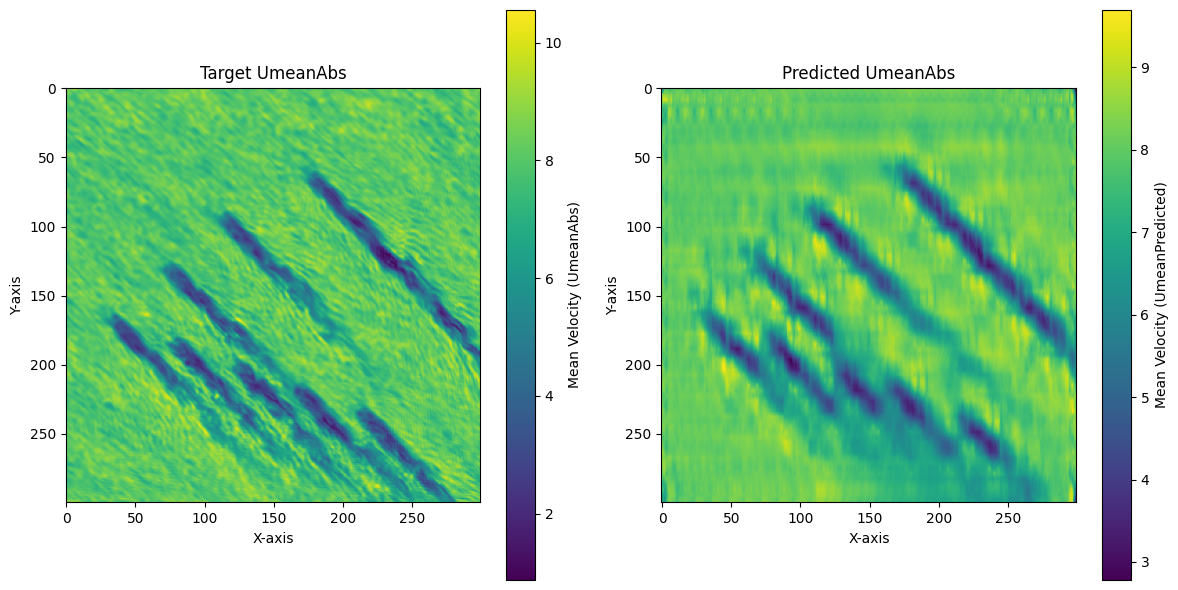

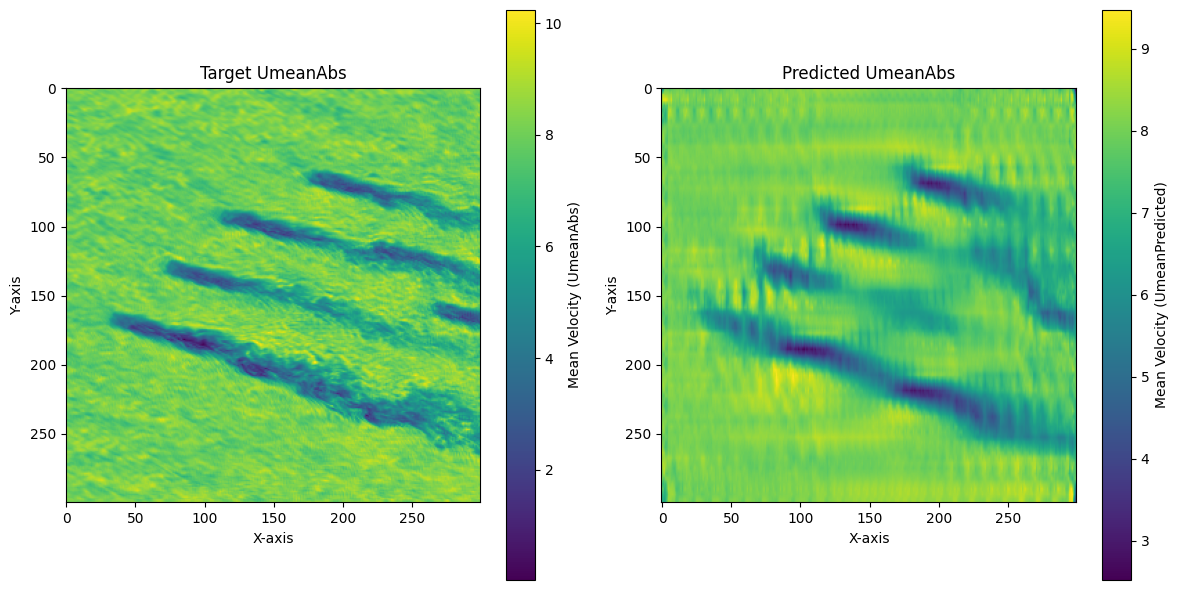

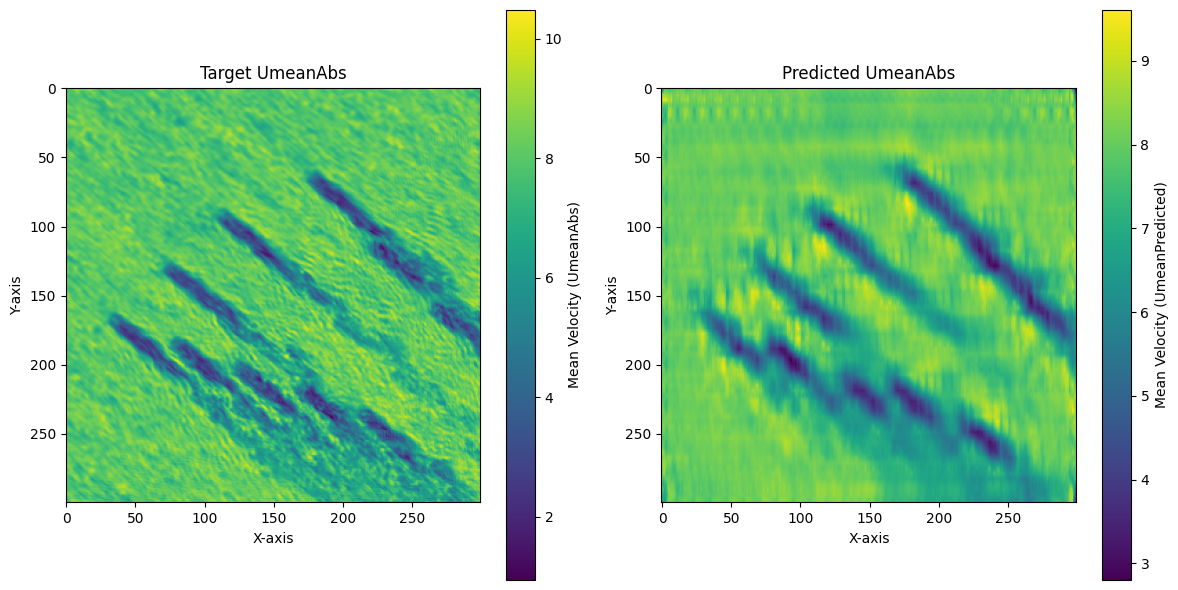

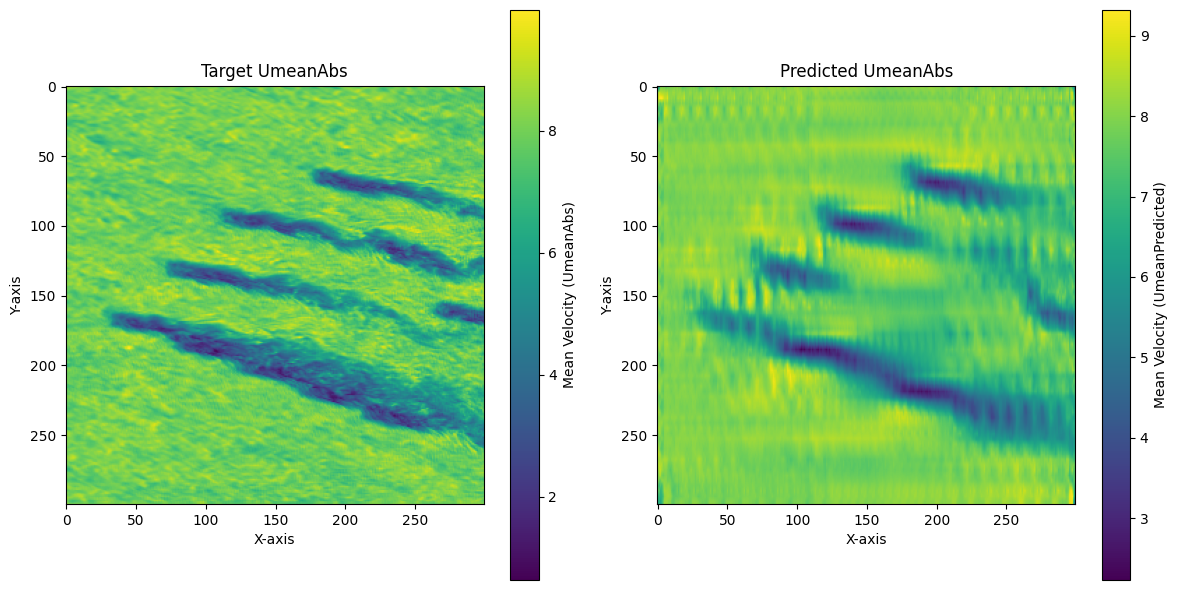

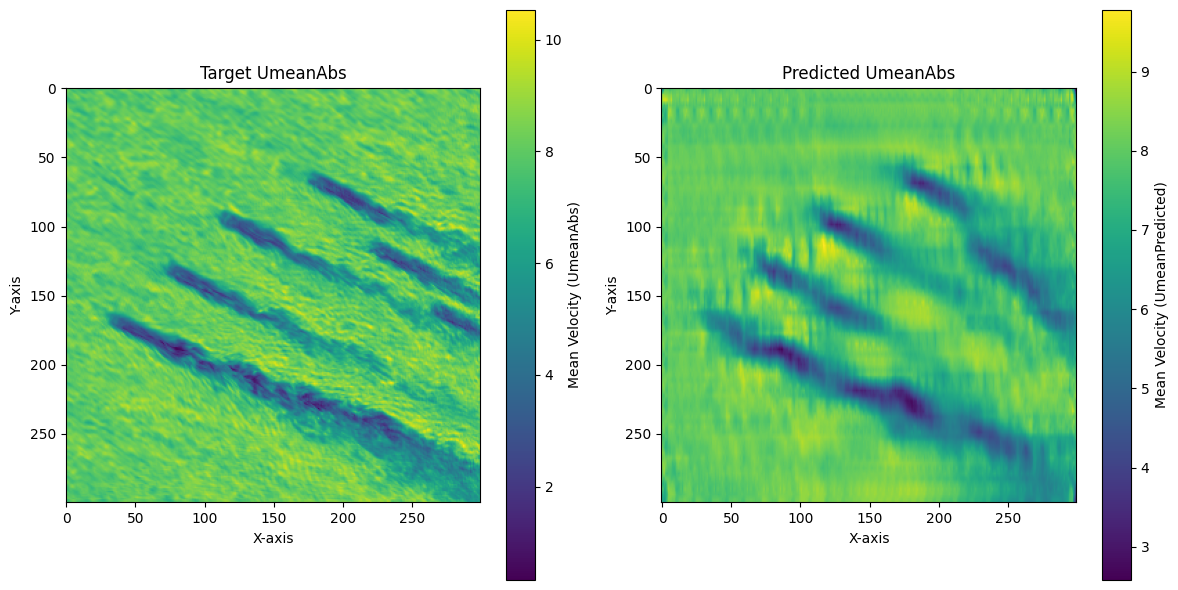

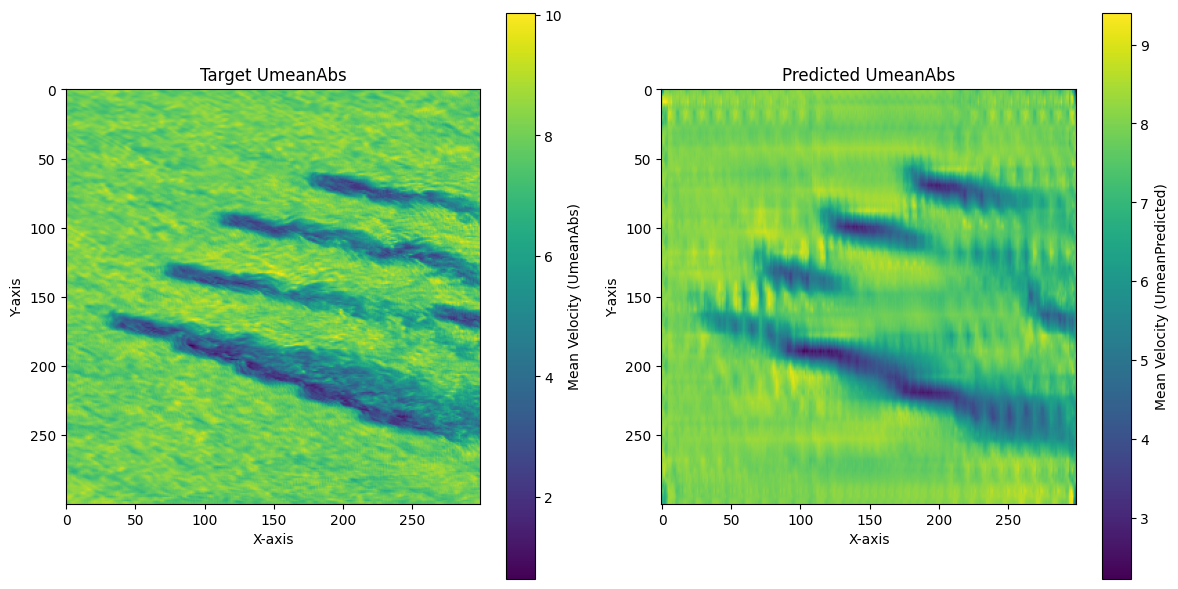

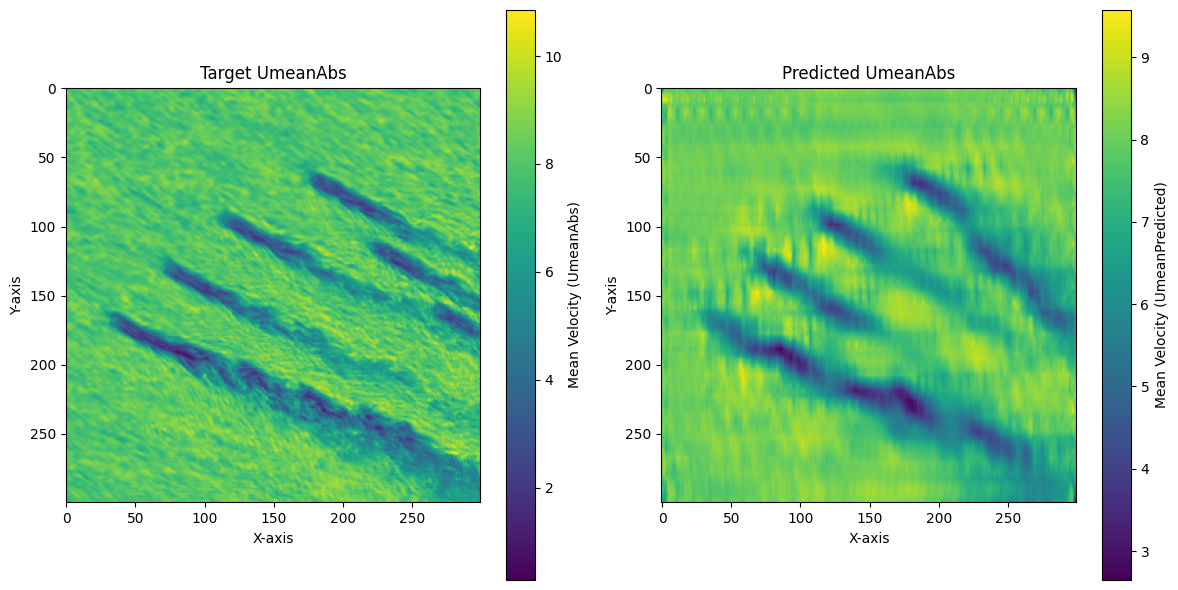

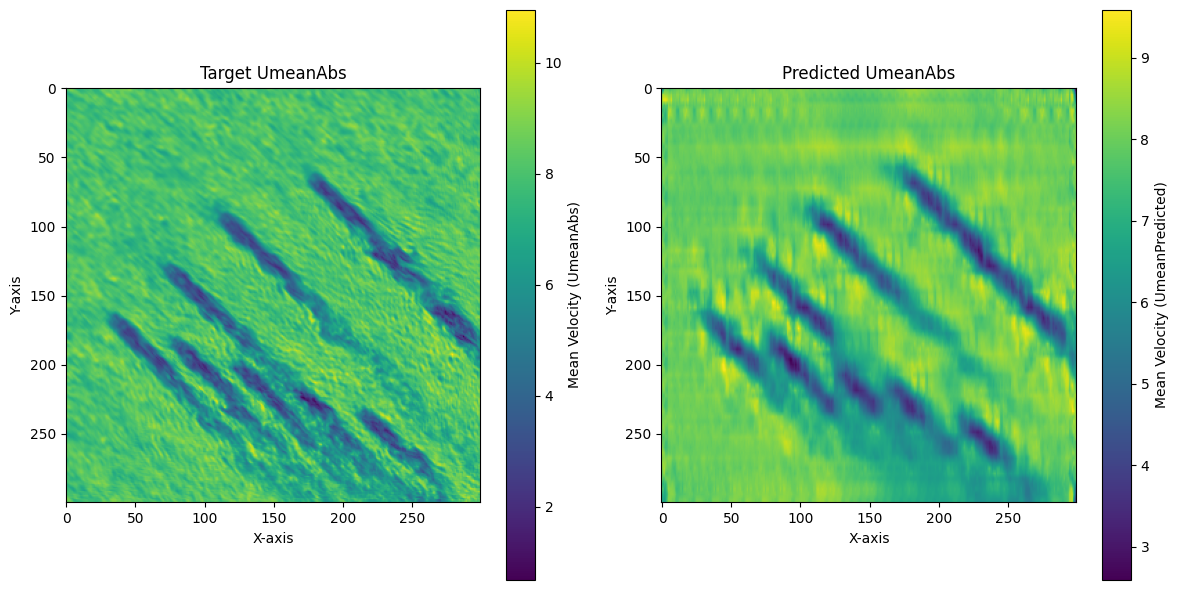

test loss: 0.7254844531416893


In [19]:
# Test a pointer on the test set
model = FlowPIGNN(**model_cfg).to(device)
model.load_state_dict(torch.load("results/20240921123615/pignn_99.pt"))
model.eval()
criterion = nn.MSELoss()

with torch.no_grad():
    test_losses = []
    for i, batch in enumerate(test_loader):
        batch = batch.to(device)
        nf = torch.cat((batch.x.to(device), batch.pos.to(device)), dim=-1).float()
        ef = batch.edge_attr.to(device).float()
        gf = batch.global_feats.to(device).float()
        pred = model(batch, nf, ef, gf)
        target = batch.y.reshape(-1, pred.size(1))
        test_loss = criterion(pred, target)
        plot_prediction_vs_real(pred[0, :].reshape(300, 300).cpu(), target[0, :].reshape(300, 300).cpu())
        test_losses.append(test_loss.item())
        model.train()

print(f"test loss: {np.mean(test_losses)}")